In [15]:
import numpy as np
import matplotlib.pyplot as plt
import mne
from tqdm import tqdm
from moabb.datasets import BNCI2014001
from mne.time_frequency import tfr_multitaper, tfr_morlet
from matplotlib.colors import TwoSlopeNorm
import pandas as pd
import seaborn as sns

### Load BCI IV / A dataset
Find the dataset description [here](https://lampz.tugraz.at/~bci/database/001-2014/description.pdf) and [here](https://neurotechx.github.io/moabb/generated/moabb.datasets.BNCI2014001.html#moabb.datasets.BNCI2014001)

In [16]:
ds = BNCI2014001()
data = ds.get_data()

### Data exploration

In [17]:
raw = data[1]['session_T']['run_0']
stims, stim_t = raw[raw.ch_names.index('stim')]
unique_events = np.unique(stims, return_counts=True)  # 0 == no event

In [18]:
# create events and epochs; check doc for timing
tmin, tmax = .8, 4  # TODO
baseline = tmin, 2
events = mne.find_events(raw, 'stim')
event_id = dict(left=1, right=2, feet=3, tongue=4)
epochs = mne.Epochs(raw, events, event_id, tmin=tmin, tmax=tmax, baseline=baseline, preload=True)

48 events found
Event IDs: [1 2 3 4]
Not setting metadata
48 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 48 events and 801 original time points ...
0 bad epochs dropped


In [36]:
epochs.copy().pick(['Cz', 'C3', 'C4']).get_data().shape

(48, 3, 801)

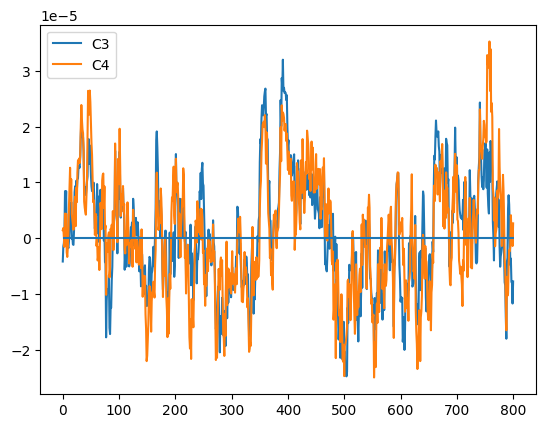

In [34]:
epoch0 = epochs.copy().pick(['Cz', 'C3', 'C4']).get_data()[0, ...]
plt.figure()
plt.plot(epoch0[1], label='C3')
plt.plot(epoch0[2], label='C4')
plt.hlines([0], xmin=0, xmax=epoch0.shape[-1])
plt.legend()
plt.show()

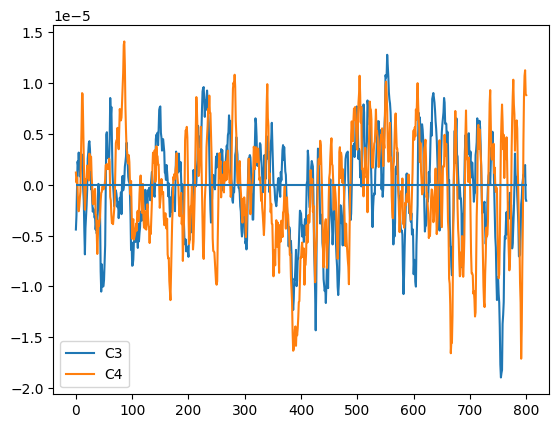

In [35]:
epoch0 = epochs.copy().pick(['Cz', 'C3', 'C4']).get_data()[0, ...]
epoch0[1] -= epoch0[0]
epoch0[2] -= epoch0[0]
plt.figure()
plt.plot(epoch0[1], label='C3')
plt.plot(epoch0[2], label='C4')
plt.hlines([0], xmin=0, xmax=epoch0.shape[-1])
plt.legend()
plt.show()

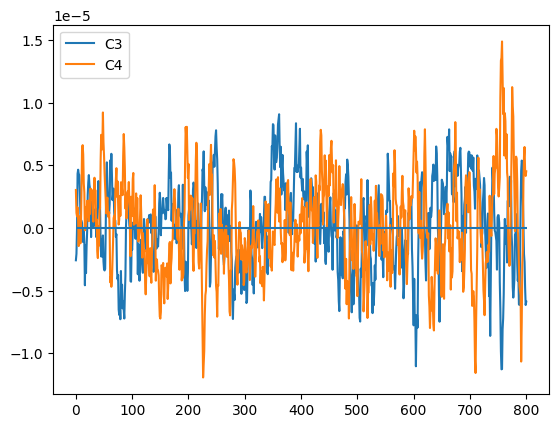

In [37]:
chans = epochs.info['ch_names']
epoch0 = epochs.copy().get_data()[0, ...]
C3 = epoch0[chans.index('C3')] - np.mean(epoch0, axis=0)
C4 = epoch0[chans.index('C4')] - np.mean(epoch0, axis=0)

plt.figure()
plt.plot(C3, label='C3')
plt.plot(C4, label='C4')
plt.hlines([0], xmin=0, xmax=epoch0.shape[-1])
plt.legend()
plt.show()

Using matplotlib as 2D backend.


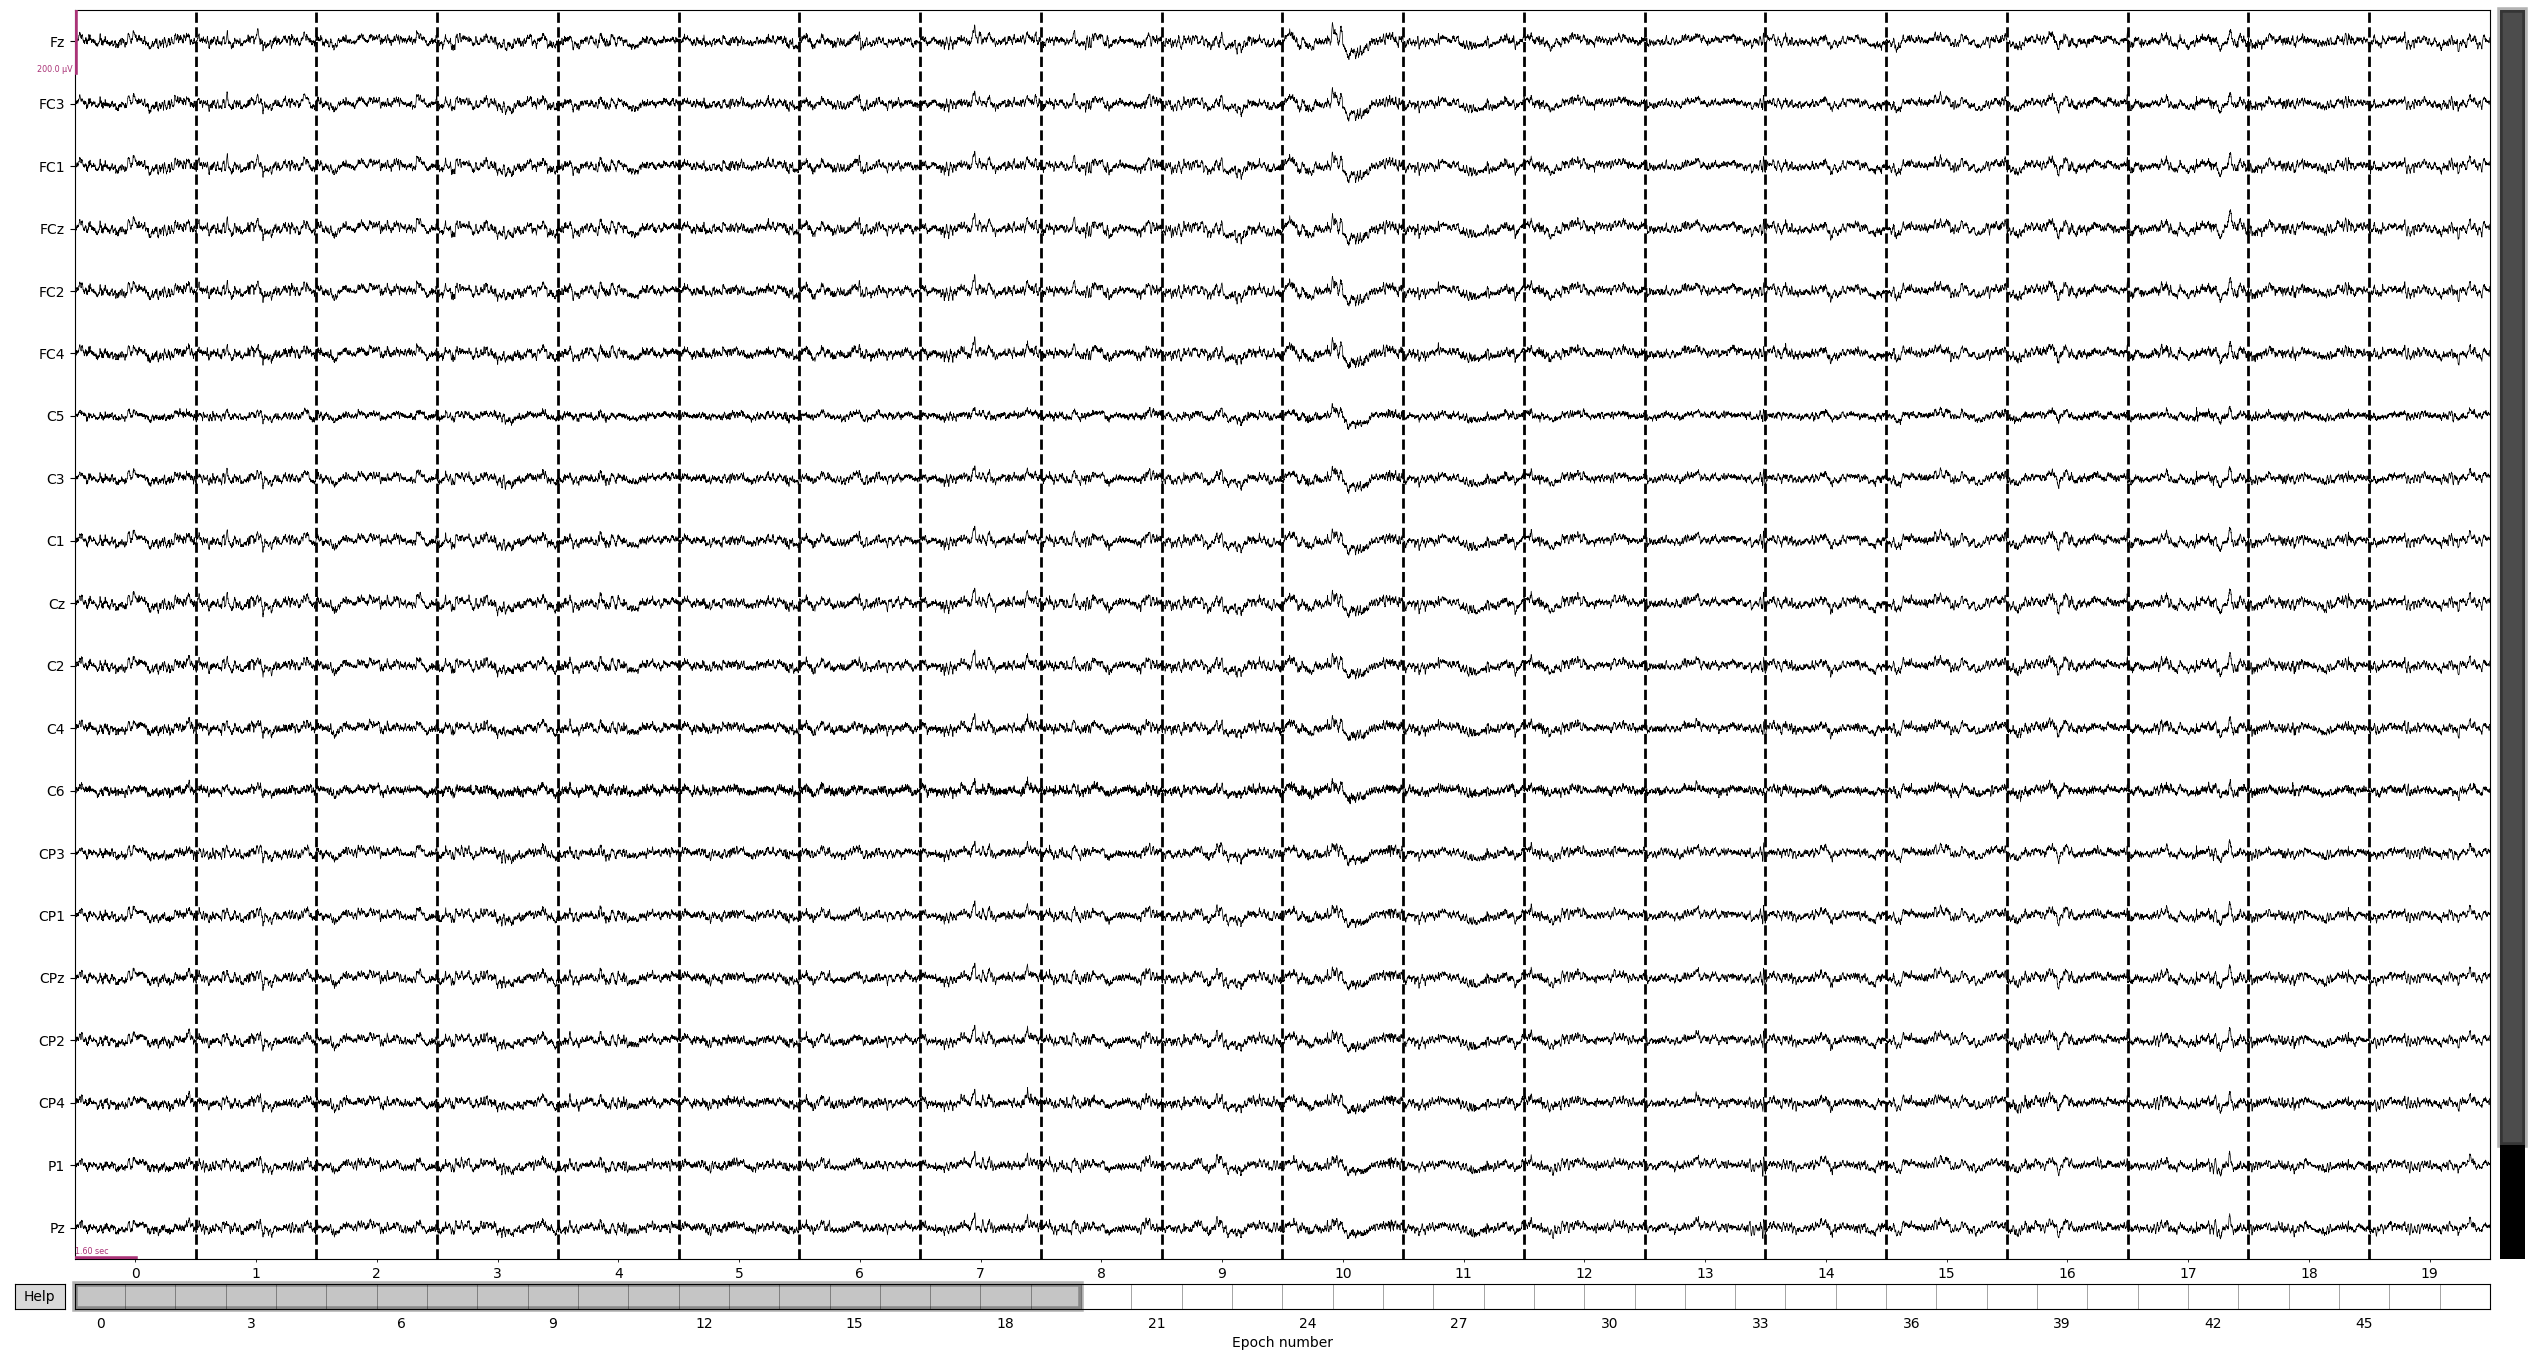

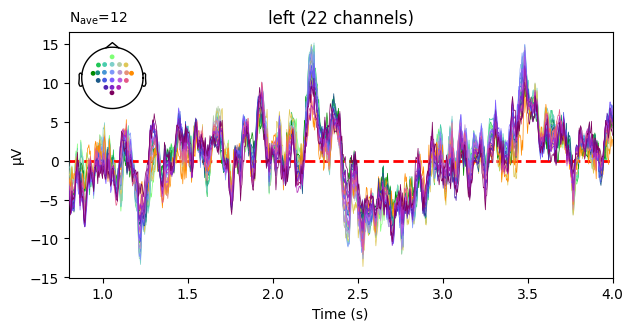

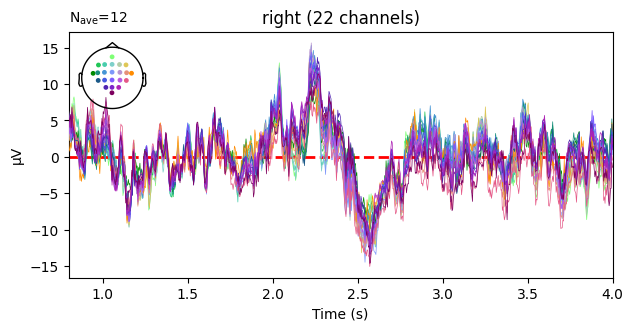

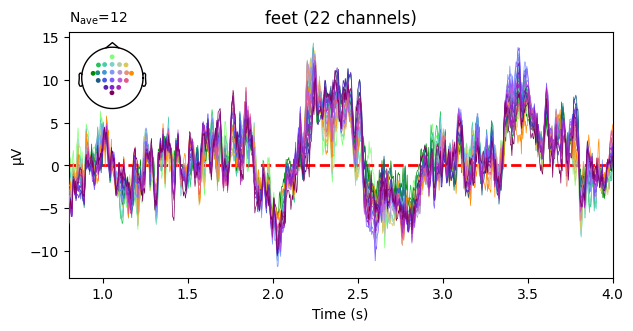

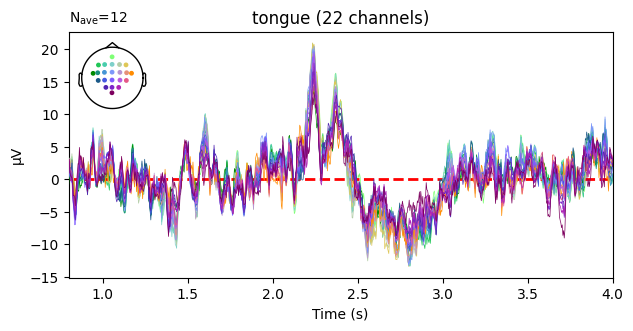

In [5]:
# plot individual epochs
epochs.plot(scalings=.0001, events=events)

# within-condition epochs averaging
for avg in epochs.average(by_event_type=True):
    avg.plot(titles=avg.comment, hline=[0])

In [14]:
epochs.info['ch_names']

['C3']

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


C:\Users\chick\AppData\Local\Programs\Python\Python39\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


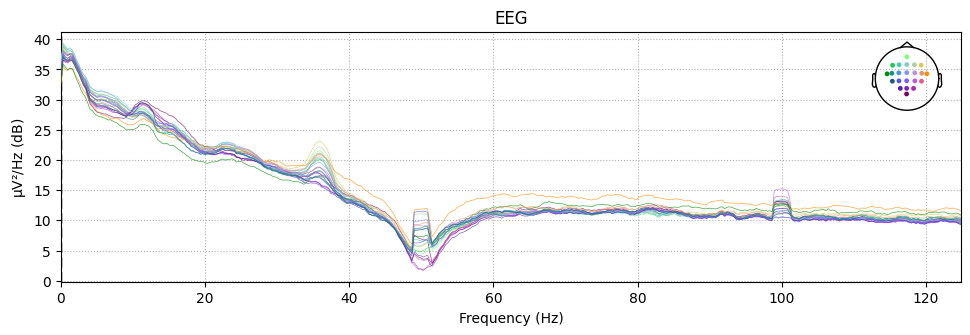

In [6]:
# check power spectral density
epochs.plot_psd()

### Epoching

In [ ]:
def prep_epoch(raw: mne.io.Raw):
    # TODO re-referencing, implement bandpass filter (0.5 - 100Hz) and notch filter (50, 100Hz)
    # TODO then apply baseline
    raw = raw.set_eeg_reference('average', projection=True, verbose=False).apply_proj()
    # raw = mne.preprocessing.compute_current_source_density(raw)
    raw = raw.filter(0.5, 40, verbose=False)
    raw = raw.notch_filter([50, 100], verbose=False)

    events = mne.find_events(raw, 'stim', verbose=False)
    event_id = dict(left=1, right=2, feet=3, tongue=4)
    epochs = mne.Epochs(raw, events, event_id, tmin=tmin, tmax=tmax, baseline=baseline, preload=True, verbose=False)

    return epochs

In [ ]:
# combine epochs
subjects = range(1, 2)  # TODO use more and more subjects
all_epochs = []
for subj_i, subj in data.items():
    if subj_i not in subjects:
        continue
    for raw in tqdm(subj['session_T'].values(), desc=str(subj_i)):
        epochs = prep_epoch(raw.copy())
        all_epochs.append(epochs)

all_epochs = mne.concatenate_epochs(all_epochs)

### Time-frequency analysis

In [ ]:
channels = ['C3', 'Cz', 'C4']
freq_rng = (7, 34.9)
nfreq = 30
# freqs = np.linspace(freq_rng[0], freq_rng[1], nfreq)
freqs = np.logspace(np.log(freq_rng[0]), np.log(freq_rng[1]), num=nfreq, base=np.e)
n_cycles = (np.log(freqs) * 2 + 2).astype(np.int32)

# plot TFR (ERDS map with masking)
vmin, vmax = -1, 1.5
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

tfr = tfr_morlet(all_epochs.copy().pick(channels), freqs=freqs, n_cycles=n_cycles, use_fft=True,
                     return_itc=False, average=False, verbose=True, n_jobs=4)
tfr = tfr.apply_baseline(baseline, mode='percent', verbose=False)

for event in tqdm(event_id.keys()):

    tfr_ev = tfr[event]

    fig, axes = plt.subplots(1, len(channels) + 1, figsize=(14, 4),
                             gridspec_kw={"width_ratios": [10] * len(channels) + [1]})

    for ch, ax in enumerate(axes[:-1]):  # for each channel
        ax.set_title(tfr.ch_names[ch], fontsize=10)
        ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
        if ch != 0:
            ax.set_ylabel("")
            ax.set_yticklabels("")

        tfr_ev.average().plot([ch], cmap="RdBu_r", cnorm=cnorm, axes=ax, colorbar=False,
                              show=False, mask=None, mask_style=None)

    cbar_src = axes[0].images[-1] if len(axes[0].images) > 0 else axes[0].collections[0]
    fig.colorbar(cbar_src, cax=axes[-1]).ax.set_yscale("linear")
    fig.suptitle(f"ERDS ({event})")

plt.show()

### Alpha ERDS analysis

In [ ]:
# erds plots
df = tfr.to_data_frame(time_format=None, long_format=True)

freq_bounds = {'_': 0,
               'delta': 3,
               'theta': 7,
               'alpha': 13,
               'beta': 35,
               'gamma': 140}
df['band'] = pd.cut(df['freq'], list(freq_bounds.values()),
                    labels=list(freq_bounds)[1:])

# Filter to retain only relevant frequency bands:
freq_bands_of_interest = ['delta', 'theta', 'alpha', 'beta']
df = df[df.band.isin(freq_bands_of_interest)]
df['band'] = df['band'].cat.remove_unused_categories()

# Order channels for plotting:
df['channel'] = df['channel'].cat.reorder_categories(channels, ordered=True)

g = sns.FacetGrid(df, row='band', col='channel', margin_titles=True)
g.map(sns.lineplot, 'time', 'value', 'condition', n_boot=10)
axline_kw = dict(color='black', linestyle='dashed', linewidth=0.5, alpha=0.5)
g.map(plt.axhline, y=0, **axline_kw)
g.map(plt.axvline, x=0, **axline_kw)
g.set(ylim=(None, 3))
g.set_axis_labels("Time (s)", "ERDS (%)")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend(ncol=2, loc='lower center')
g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.08)

plt.show()